# DEC Supervised Clustering

This notebook focuses on using some kind of supervision for helping the clustering. This includes different techniques that we discussed with Dr. Ece Kamar from Microsoft during her visit to UMN. The different techniques include: 
    1. Initializing cluster centers based on highly confident galaxy images
        a. Run K-Means on encoded features learned from autoencoder for top 10-20 high confident images of each class and check whether K-Means is able to successfully cluster the features into two different cluster with high purity
        b. Analyze the PCA plot of the encoded features learned from autoencoder for top 10-20 high confident images of each class for visible distinct cluster
    2. Providing some kind of feedback on how good/bad clustering was in the previous iteration
        a. Not sure?

Some other techniques that we are also trying to include and analyse are:
    3. Clustering over a quadrant of the image to try to get rid of the worm shape PCA plot
        a. Input images are crops of the original images but of the top left quadrant
    4. Using different clustering techniques which include denisty and heirarchical clustering
        a. DBSCAN
        b. Agglomerative Clustering
        c. Heirarchical Clustering
        d. Spectral Clustering
        
        refer to the webpage: https://scikit-learn.org/stable/modules/clustering.html

## K-Means Cluster Initialization

### Importing required Libaries

Importing the required libraries and modules so that they can be used in the notebook

In [1]:
import tensorflow as tf
import keras.backend as K
import numpy as np
import pandas as pd
# loading the requirements for the Xception model
from keras.applications.xception import Xception
from keras.applications.xception import absolute_import, decode_predictions, preprocess_input
from keras.layers import Flatten, Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
# Loading the DEC module cloned from github
from DEC.model import *
from DEC.metrics import *
from xception_dec_datagenerator import XceptionDataGenerator
# Importing the utilities
from utils.file_utils import *
from PIL import Image
# Using scikit-image  resize function for resizing the image from original size to 224 X 224
from skimage.transform import resize
# Train Test split from sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from shutil import copy2
# For visualization of images and for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings('ignore')

### Xception Model

First we load the Xception model into the computer memory using the Keras library. Because we are focusing on extracting features from the model we do not include the topmost layer. However we do use the imagenet weights for the model. Also because we want a 1-D vector form of the features we do use the pooling layer at the end.

In [3]:
input_tensor_shape = (150, 150, 3)
base_xception_model = Xception(weights = 'imagenet', input_shape = input_tensor_shape, include_top = False, pooling='avg')
base_xception_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

The input shape of our base xception model is: 150 X 150 X 3. That is a 3 channel square image with side 150 pixels.
The output shape of the base xception model is: 2048 X 1. It is a 1-D vector representing the features learned by the model

### Loading the Galaxy Zoo data

We now start loading the galaxy zoo data into memory. First we load the label file and then start loading the corresponding images such that we can assign the corresponding label to them

In [4]:
all_labels = pd.read_csv(f'../data/galaxy_zoo/training_solutions_rev1.csv')
all_labels.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [5]:
# First we can get rid of all the extra data that we will not use

# Assuming the follwing column names:
elliptical_galaxy_col_name = 'Class1.1'
spiral_galaxy_col_name = 'Class1.2'

all_labels = all_labels[['GalaxyID', elliptical_galaxy_col_name, spiral_galaxy_col_name]]
all_labels.head()

,GalaxyID,Class1.1,Class1.2
0,100008,0.383147,0.616853
1,100023,0.327001,0.663777
2,100053,0.765717,0.177352
3,100078,0.693377,0.238564
4,100090,0.933839,0.000000


In [6]:
# Getting the id's for elliptical and spiral galaxies
elliptical_galaxy_ids = pd.Series(all_labels[all_labels[elliptical_galaxy_col_name] >= 0.5]['GalaxyID'], dtype=str)
spiral_galaxy_ids = pd.Series(all_labels[all_labels[spiral_galaxy_col_name] > 0.5]['GalaxyID'], dtype=str)

In [7]:
# Finding the number of images for each type of galaxy
print(f'Number Elliptical Galaxies: {elliptical_galaxy_ids.shape[0]}')
print(f'Number Spiral Galaxies: {spiral_galaxy_ids.shape[0]}')

Number Elliptical Galaxies: 25868
Number Spiral Galaxies: 34105


__Finding High Confidence Galaxies__

In [8]:
# First find the number of high confidence galaxies for both classes
conf_threshold = 1.0
print(f'Confidence Threshold: {conf_threshold}')
num_high_conf_elliptical_galaxies = all_labels[all_labels[elliptical_galaxy_col_name] >= conf_threshold].shape[0]
num_high_conf_spiral_galaxies = all_labels[all_labels[spiral_galaxy_col_name] >= conf_threshold].shape[0]
print('Number of High Confidence Elliptical Galaxies:', num_high_conf_elliptical_galaxies)
print('Number of High Confidence Spiral Galaxies:', num_high_conf_spiral_galaxies)

Confidence Threshold: 1.0
Number of High Confidence Elliptical Galaxies: 146
Number of High Confidence Spiral Galaxies: 711


In [9]:
# sampling certain number of high confidence galaxies
num_samples = 20
high_conf_ellip_galaxies = all_labels.sort_values(by=elliptical_galaxy_col_name, ascending=False).iloc[:min(num_high_conf_elliptical_galaxies, num_high_conf_spiral_galaxies)].sample(num_samples)['GalaxyID']
high_conf_spiral_galaxies = all_labels.sort_values(by=spiral_galaxy_col_name, ascending=False).iloc[:min(num_high_conf_elliptical_galaxies, num_high_conf_spiral_galaxies)].sample(num_samples)['GalaxyID']

In [10]:
high_conf_ellip_galaxies

15634    331167
58228    950850
46723    780875
16504    343866
53445    879329
23529    443715
7518     210465
7036     203829
15894    335161
47849    797160
38593    662983
40982    697454
19172    381567
15533    329807
8056     218281
5699     184703
15924    335528
17531    358458
23484    442980
45020    757010
Name: GalaxyID, dtype: int64

In [11]:
high_conf_spiral_galaxies

50426    834360
61364    996854
12965    292016
58311    951919
44287    746056
38979    668583
12553    285593
14856    320105
22780    432849
54134    889854
41528    706376
39066    669881
16680    346007
14839    319856
2747     141084
58713    957751
31447    561522
27458    502352
27126    497199
57461    938845
Name: GalaxyID, dtype: int64

### Data Generators

Defining the keras data generators to iterate through all the images and then essentially help in extracting the features from the images

In [12]:
image_extension = '.jpg'
training_directory_path = f'../data/xception_clustering/training/'
testing_directory_path = f'../data/xception_clustering/testing/'

In [13]:
# Getting the files already in the training and testing folders respectively
spiral_training_directory_path = construct_path(training_directory_path, 'spiral')
elliptical_training_directory_path = construct_path(training_directory_path, 'elliptical')
spiral_testing_directory_path = construct_path(testing_directory_path, 'spiral')
elliptical_testing_directory_path = construct_path(testing_directory_path, 'elliptical')
elliptical_training_files = get_file_nms(elliptical_training_directory_path, image_extension)
spiral_training_files = get_file_nms(spiral_training_directory_path, image_extension)
elliptical_testing_files = get_file_nms(elliptical_testing_directory_path, image_extension)
spiral_testing_files = get_file_nms(spiral_testing_directory_path, image_extension)
# Finding the number of images for each type of galaxy after finding the common images and list
print(f'Number of already present Training Elliptical Galaxies: {len(elliptical_training_files)}')
print(f'Number of already present Training Spiral Galaxies: {len(spiral_training_files)}')
print(f'Number of already present Testing Elliptical Galaxies: {len(elliptical_testing_files)}')
print(f'Number of already present Testing Spiral Galaxies: {len(spiral_testing_files)}')

Number of already present Training Elliptical Galaxies: 25868
Number of already present Training Spiral Galaxies: 34105
Number of already present Testing Elliptical Galaxies: 0
Number of already present Testing Spiral Galaxies: 0


#### Normalization and Cropping functions

In [14]:
def get_difference(orig_size, target_size):
    orig_size, target_size = list(orig_size), list(target_size)
    ret_ls = []
    for o, t in zip(orig_size, target_size):
        ret_ls.append(o - t)
    return ret_ls

def crop_image(image, orig_size, target_size):
    crop_sizes = get_difference(orig_size, target_size)
    height_dif, width_dif = crop_sizes[0] // 2, crop_sizes[1] // 2
    return image[height_dif:(height_dif + target_size[0]), width_dif:(width_dif + target_size[1]), :]

def range_scaling(image, out_feature_range=(-1, 1)):
    old_min, old_max = 0., 255.
    new_min, new_max = -1., 1.
    return ((image - old_min)/(old_max - old_min))*(new_max - new_min) + new_min

def image_preprocessing_function(image, crop=True, range_scale=True):
    """
    image is a 3-D image tensor (numpy array).
    """
    target_image_size = input_tensor_shape
    if crop:
        cropped_image = crop_image(image, image.shape, target_image_size)
    else:
        cropped_image = image
        
    if range_scale:
        final_image = range_scaling(cropped_image)
    else:
        final_image = cropped_image
    return final_image

#### Generator Definitions

In [15]:
%%time
generator_batch_size = 64
# Current generator uses -1 to 1
image_generator = ImageDataGenerator(preprocessing_function=image_preprocessing_function)
training_generator = image_generator.flow_from_directory(training_directory_path, target_size = input_tensor_shape[:2], 
                                                         class_mode='binary', batch_size=generator_batch_size)
testing_generator = image_generator.flow_from_directory(testing_directory_path, target_size = input_tensor_shape[:2], 
                                                         class_mode='binary', batch_size=generator_batch_size)

Found 59973 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
CPU times: user 3.74 s, sys: 716 ms, total: 4.46 s
Wall time: 3.03 s


In [16]:
%%time
n_train_examples = (len(training_generator.filenames)//generator_batch_size) * generator_batch_size
train_features = np.zeros((n_train_examples, 2048))
train_labels = np.zeros(n_train_examples, dtype=int)
i = 0
for inputs_batch, labels_batch in training_generator:
    features_batch = base_xception_model.predict(inputs_batch)
    train_features[i * generator_batch_size : (i + 1) * generator_batch_size] = features_batch
    train_labels[i * generator_batch_size : (i + 1) * generator_batch_size] = labels_batch
    i += 1
    if i % 100 == 0 and i:
        print('Number of Images processed:', i * generator_batch_size)
    if i * generator_batch_size >= n_train_examples:
        break

print('Shape of the training features', train_features.shape)

Number of Images processed: 6400
Number of Images processed: 12800
Number of Images processed: 19200
Number of Images processed: 25600
Number of Images processed: 32000
Number of Images processed: 38400
Number of Images processed: 44800
Number of Images processed: 51200
Number of Images processed: 57600
Shape of the training features (59968, 2048)
CPU times: user 6min 38s, sys: 1min 27s, total: 8min 6s
Wall time: 7min 42s


In [17]:
training_generator.class_indices

{'elliptical': 0, 'spiral': 1}

### Experiment 1: K-Means Clustering Average Features Cluster initialization

#### DEC Xception Training Regime

This part of the notebook defines the generator for the training regime of the DEC model over the features extracted from the Xception architecture

In [18]:
# Defining our DEC model
dec_model = DEC([2048, 500, 500, 2000, 10], n_clusters=2)
dec_model.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2048)              0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               1024500   
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 2)                 20        
Total params: 2,297,030
Trainable params: 2,297,030
Non-trainable params: 0
_________________________________________________________________


In [19]:
results_save_dir = 'results/kmeans_clustering_cluster_initialization_average'
if not exist_directory(results_save_dir):
    os.makedirs(results_save_dir)

#### Pretraining

In [20]:
%%time
dec_model.pretrain(train_features, train_labels, epochs=100, save_dir=results_save_dir)

...Pretraining...
Epoch 1/100
59968/59968 [==============================] - 5s 85us/step - loss: 0.0160
        |==>  acc: 0.6938,  nmi: 0.1096  <==|
Epoch 2/100
59968/59968 [==============================] - 4s 70us/step - loss: 0.0080
Epoch 3/100
59968/59968 [==============================] - 4s 69us/step - loss: 0.0070
Epoch 4/100
59968/59968 [==============================] - 5s 76us/step - loss: 0.0067
Epoch 5/100
59968/59968 [==============================] - 4s 71us/step - loss: 0.0065
Epoch 6/100
59968/59968 [==============================] - 4s 71us/step - loss: 0.0064
Epoch 7/100
59968/59968 [==============================] - 4s 71us/step - loss: 0.0063
Epoch 8/100
59968/59968 [==============================] - 4s 69us/step - loss: 0.0062
Epoch 9/100
59968/59968 [==============================] - 4s 69us/step - loss: 0.0061
Epoch 10/100
59968/59968 [==============================] - 4s 68us/step - loss: 0.0060
Epoch 11/100
59968/59968 [==============================] - 4s 69

#### Cluster Centers

In [21]:
get_subdirectory_names(training_directory_path)

['spiral/', 'elliptical/']

In [22]:
high_conf_ellip_im_arr = []
for galaxy_id in high_conf_ellip_galaxies:
    image_path = construct_path(elliptical_training_directory_path, f'{galaxy_id}{image_extension}')
    high_conf_ellip_im_arr.append(image_preprocessing_function(np.array(Image.open(image_path))))
high_conf_ellip_im_arr = np.array(high_conf_ellip_im_arr)

high_conf_spiral_im_arr = []
for galaxy_id in high_conf_spiral_galaxies:
    image_path = construct_path(spiral_training_directory_path, f'{galaxy_id}{image_extension}')
    high_conf_spiral_im_arr.append(image_preprocessing_function(np.array(Image.open(image_path))))
high_conf_spiral_im_arr = np.array(high_conf_spiral_im_arr)

#### High Confidence Images Base Xception Model Features

In [23]:
%%time
# Getting the prediction
high_conf_ellip_pred = base_xception_model.predict(high_conf_ellip_im_arr)
high_conf_spiral_pred = base_xception_model.predict(high_conf_spiral_im_arr)
high_conf_pred = np.vstack((high_conf_ellip_pred, high_conf_spiral_pred))
high_conf_label = ['Elliptical']*num_samples + ['Spiral']*num_samples

CPU times: user 660 ms, sys: 352 ms, total: 1.01 s
Wall time: 999 ms


#### PCA Visualization

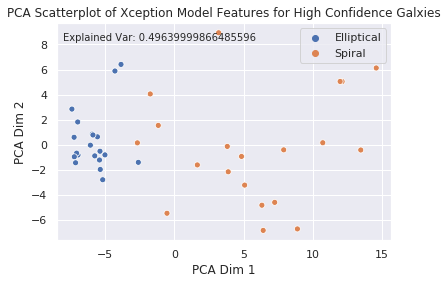

In [24]:
pca_mod = PCA(2)
pca_mod.fit(high_conf_pred)
reduced_features = pca_mod.transform(high_conf_pred)

fig, ax = plt.subplots(1, 1)
sns.scatterplot(reduced_features[:, 0], reduced_features[:, 1], 
                hue=high_conf_label, ax=ax)
ax.text(0.02, 0.92, f'Explained Var: {np.round(np.sum(pca_mod.explained_variance_ratio_), decimals=4)}', 
        transform=ax.transAxes)
ax.set_xlabel('PCA Dim 1')
ax.set_ylabel('PCA Dim 2')
ax.set_title('PCA Scatterplot of Xception Model Features for High Confidence Galxies')
plt.savefig(f'{results_save_dir}/PCA_Base_Xception_Model_High_Confidence_Predictions.png')

#### High Confidence Images Pretrain Model Prediction

In [25]:
%%time
# Getting the prediction
high_conf_encoder_features = dec_model.encoder.predict(high_conf_pred)

CPU times: user 164 ms, sys: 68 ms, total: 232 ms
Wall time: 167 ms


#### PCA Visualization

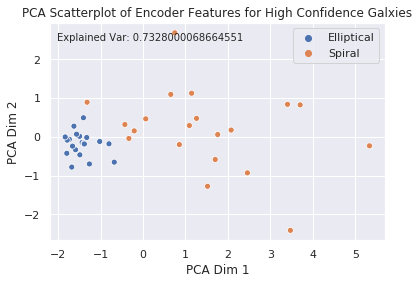

In [26]:
pca_mod = PCA(2)
pca_mod.fit(high_conf_encoder_features)
reduced_features = pca_mod.transform(high_conf_encoder_features)

fig, ax = plt.subplots(1, 1)
sns.scatterplot(reduced_features[:, 0], reduced_features[:, 1], 
                hue=high_conf_label, ax=ax)
ax.text(0.02, 0.92, f'Explained Var: {np.round(np.sum(pca_mod.explained_variance_ratio_), decimals=4)}', 
        transform=ax.transAxes)
ax.set_xlabel('PCA Dim 1')
ax.set_ylabel('PCA Dim 2')
ax.set_title('PCA Scatterplot of Encoder Features for High Confidence Galxies')
plt.savefig(f'{results_save_dir}/PCA_Pretrain_Model_High_Confidence_Predictions.png')

#### Experiment 1: Cluster Center Initialization: Average Features

In [27]:
ellip_center = np.mean(high_conf_encoder_features[:num_samples], axis=0)
spiral_center = np.mean(high_conf_encoder_features[num_samples:], axis=0)
kmeans_init_center = np.array([ellip_center, spiral_center])
kmeans_init_center.shape

(2, 10)

#### Clustering

In [28]:
%%time
dec_model.compile(optimizer=SGD(0.01, 0.9), loss='kld')
y_pred = dec_model.fit(train_features, y=train_labels, batch_size=32, save_dir=results_save_dir, 
                       kmeans_init=kmeans_init_center)
print('acc:', metrics.acc(train_labels, y_pred))

Update interval 140
Save interval 9370
Initializing cluster centers with k-means.
Iter 0: acc = 0.69335, nmi = 0.10775, ari = 0.14943  ; loss= 0
saving model to: results/kmeans_clustering_cluster_initialization_average/DEC_model_0.h5
Iter 140: acc = 0.69197, nmi = 0.10907, ari = 0.14737  ; loss= 0.00042
Iter 280: acc = 0.69003, nmi = 0.10828, ari = 0.14443  ; loss= 0.00196
Iter 420: acc = 0.69175, nmi = 0.11067, ari = 0.14706  ; loss= 0.00786
Iter 560: acc = 0.69304, nmi = 0.11271, ari = 0.14904  ; loss= 0.02608
Iter 700: acc = 0.69335, nmi = 0.11296, ari = 0.14953  ; loss= 0.03989
Iter 840: acc = 0.69530, nmi = 0.11458, ari = 0.15255  ; loss= 0.03905
Iter 980: acc = 0.69490, nmi = 0.11458, ari = 0.15193  ; loss= 0.03546
Iter 1120: acc = 0.69397, nmi = 0.11460, ari = 0.15048  ; loss= 0.03626
Iter 1260: acc = 0.69370, nmi = 0.11421, ari = 0.15007  ; loss= 0.03336
Iter 1400: acc = 0.69647, nmi = 0.11552, ari = 0.15438  ; loss= 0.02725
Iter 1540: acc = 0.69332, nmi = 0.11296, ari = 0.1494

### Visualization of the features extracted by the DEC model

#### Encoder Output Features

CPU times: user 6.84 s, sys: 1.11 s, total: 7.96 s
Wall time: 6.16 s


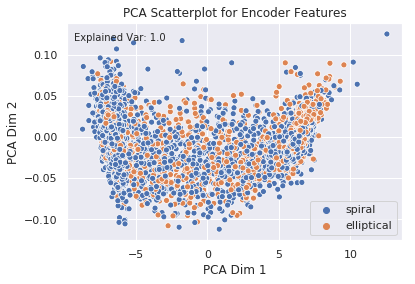

In [29]:
%%time
dec_encoder_model_pred = dec_model.encoder.predict(train_features)
pca_mod = PCA(2)
pca_mod.fit(dec_encoder_model_pred)
reduced_features = pca_mod.transform(dec_encoder_model_pred)

fig, ax = plt.subplots(1, 1)
sns.scatterplot(reduced_features[:, 0], reduced_features[:, 1], 
                hue=np.where(train_labels==0, 'elliptical', 'spiral'), ax=ax)
ax.text(0.02, 0.92, f'Explained Var: {np.round(np.sum(pca_mod.explained_variance_ratio_), decimals=4)}', 
        transform=ax.transAxes)
ax.set_xlabel('PCA Dim 1')
ax.set_ylabel('PCA Dim 2')
ax.set_title('PCA Scatterplot for Encoder Features')
plt.savefig(f'{results_save_dir}/PCAencoding_pca_features.png')

### Experiment 2: K-Means Clustering Point Features Cluster initialization

#### DEC Xception Training Regime

This part of the notebook defines the generator for the training regime of the DEC model over the features extracted from the Xception architecture

In [30]:
# Defining our DEC model
dec_model = DEC([2048, 500, 500, 2000, 10], n_clusters=2)
dec_model.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2048)              0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               1024500   
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 2)                 20        
Total params: 2,297,030
Trainable params: 2,297,030
Non-trainable params: 0
_________________________________________________________________


In [31]:
results_save_dir = 'results/kmeans_clustering_cluster_initialization_point'
if not exist_directory(results_save_dir):
    os.makedirs(results_save_dir)

#### Pretraining

In [32]:
%%time
dec_model.pretrain(train_features, train_labels, epochs=100, save_dir=results_save_dir)

...Pretraining...
Epoch 1/100
59968/59968 [==============================] - 5s 86us/step - loss: 0.0151
        |==>  acc: 0.6793,  nmi: 0.0940  <==|
Epoch 2/100
59968/59968 [==============================] - 4s 68us/step - loss: 0.0080
Epoch 3/100
59968/59968 [==============================] - 4s 68us/step - loss: 0.0071
Epoch 4/100
59968/59968 [==============================] - 4s 69us/step - loss: 0.0067
Epoch 5/100
59968/59968 [==============================] - 4s 70us/step - loss: 0.0065
Epoch 6/100
59968/59968 [==============================] - 4s 71us/step - loss: 0.0064
Epoch 7/100
59968/59968 [==============================] - 4s 68us/step - loss: 0.0063
Epoch 8/100
59968/59968 [==============================] - 4s 68us/step - loss: 0.0062
Epoch 9/100
59968/59968 [==============================] - 4s 69us/step - loss: 0.0061
Epoch 10/100
59968/59968 [==============================] - 4s 68us/step - loss: 0.0060
Epoch 11/100
59968/59968 [==============================] - 4s 68

#### Cluster Centers

In [33]:
get_subdirectory_names(training_directory_path)

['spiral/', 'elliptical/']

In [34]:
high_conf_ellip_im_arr = []
for galaxy_id in high_conf_ellip_galaxies:
    image_path = construct_path(elliptical_training_directory_path, f'{galaxy_id}{image_extension}')
    high_conf_ellip_im_arr.append(image_preprocessing_function(np.array(Image.open(image_path))))
high_conf_ellip_im_arr = np.array(high_conf_ellip_im_arr)

high_conf_spiral_im_arr = []
for galaxy_id in high_conf_spiral_galaxies:
    image_path = construct_path(spiral_training_directory_path, f'{galaxy_id}{image_extension}')
    high_conf_spiral_im_arr.append(image_preprocessing_function(np.array(Image.open(image_path))))
high_conf_spiral_im_arr = np.array(high_conf_spiral_im_arr)

#### High Confidence Images Base Xception Model Features

In [35]:
%%time
# Getting the prediction
high_conf_ellip_pred = base_xception_model.predict(high_conf_ellip_im_arr)
high_conf_spiral_pred = base_xception_model.predict(high_conf_spiral_im_arr)
high_conf_pred = np.vstack((high_conf_ellip_pred, high_conf_spiral_pred))
high_conf_label = ['Elliptical']*num_samples + ['Spiral']*num_samples

CPU times: user 196 ms, sys: 116 ms, total: 312 ms
Wall time: 288 ms


#### PCA Visualization

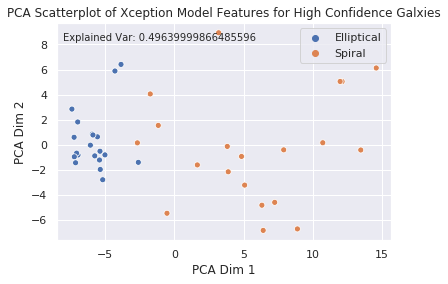

In [36]:
pca_mod = PCA(2)
pca_mod.fit(high_conf_pred)
reduced_features = pca_mod.transform(high_conf_pred)

fig, ax = plt.subplots(1, 1)
sns.scatterplot(reduced_features[:, 0], reduced_features[:, 1], 
                hue=high_conf_label, ax=ax)
ax.text(0.02, 0.92, f'Explained Var: {np.round(np.sum(pca_mod.explained_variance_ratio_), decimals=4)}', 
        transform=ax.transAxes)
ax.set_xlabel('PCA Dim 1')
ax.set_ylabel('PCA Dim 2')
ax.set_title('PCA Scatterplot of Xception Model Features for High Confidence Galxies')
plt.savefig(f'{results_save_dir}/PCA_Base_Xception_Model_High_Confidence_Predictions.png')

#### High Confidence Images Pretrain Model Prediction

In [37]:
%%time
# Getting the prediction
high_conf_encoder_features = dec_model.encoder.predict(high_conf_pred)

CPU times: user 248 ms, sys: 60 ms, total: 308 ms
Wall time: 239 ms


#### PCA Visualization

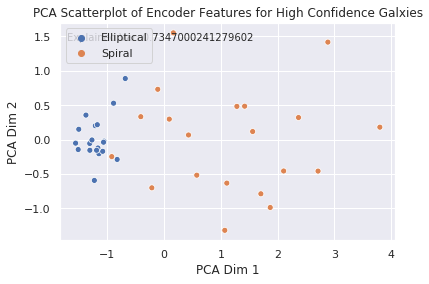

In [38]:
pca_mod = PCA(2)
pca_mod.fit(high_conf_encoder_features)
reduced_features = pca_mod.transform(high_conf_encoder_features)

fig, ax = plt.subplots(1, 1)
sns.scatterplot(reduced_features[:, 0], reduced_features[:, 1], 
                hue=high_conf_label, ax=ax)
ax.text(0.02, 0.92, f'Explained Var: {np.round(np.sum(pca_mod.explained_variance_ratio_), decimals=4)}', 
        transform=ax.transAxes)
ax.set_xlabel('PCA Dim 1')
ax.set_ylabel('PCA Dim 2')
ax.set_title('PCA Scatterplot of Encoder Features for High Confidence Galxies')
plt.savefig(f'{results_save_dir}/PCA_Pretrain_Model_High_Confidence_Predictions.png')

#### Experiment 1: Cluster Center Initialization: Average Features

In [39]:
ellip_center = high_conf_encoder_features[0]
spiral_center = high_conf_encoder_features[num_samples]
kmeans_init_center = np.array([ellip_center, spiral_center])
kmeans_init_center.shape

(2, 10)

#### Clustering

In [40]:
%%time
dec_model.compile(optimizer=SGD(0.01, 0.9), loss='kld')
y_pred = dec_model.fit(train_features, y=train_labels, batch_size=32, save_dir=results_save_dir, 
                       kmeans_init=kmeans_init_center)
print('acc:', metrics.acc(train_labels, y_pred))

Update interval 140
Save interval 9370
Initializing cluster centers with k-means.
Iter 0: acc = 0.68927, nmi = 0.10530, ari = 0.14324  ; loss= 0
saving model to: results/kmeans_clustering_cluster_initialization_point/DEC_model_0.h5
Iter 140: acc = 0.68718, nmi = 0.10442, ari = 0.14013  ; loss= 0.00039
Iter 280: acc = 0.68482, nmi = 0.10303, ari = 0.13661  ; loss= 0.00211
Iter 420: acc = 0.68662, nmi = 0.10476, ari = 0.13929  ; loss= 0.00839
Iter 560: acc = 0.68517, nmi = 0.10394, ari = 0.13713  ; loss= 0.02845
Iter 700: acc = 0.68478, nmi = 0.10318, ari = 0.13656  ; loss= 0.04049
Iter 840: acc = 0.68580, nmi = 0.10426, ari = 0.13807  ; loss= 0.04104
Iter 980: acc = 0.68695, nmi = 0.10565, ari = 0.13979  ; loss= 0.04129
Iter 1120: acc = 0.68560, nmi = 0.10521, ari = 0.13777  ; loss= 0.03406
Iter 1260: acc = 0.68560, nmi = 0.10516, ari = 0.13777  ; loss= 0.03199
Iter 1400: acc = 0.68600, nmi = 0.10532, ari = 0.13837  ; loss= 0.03165
Iter 1540: acc = 0.68825, nmi = 0.10728, ari = 0.14174 

### Visualization of the features extracted by the DEC model

#### Encoder Output Features

CPU times: user 6.88 s, sys: 956 ms, total: 7.83 s
Wall time: 6.04 s


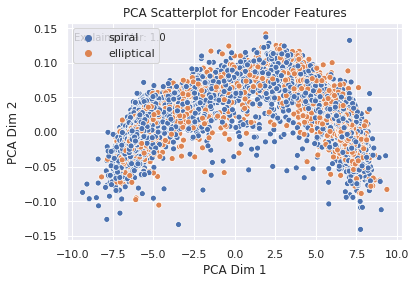

In [41]:
%%time
dec_encoder_model_pred = dec_model.encoder.predict(train_features)
pca_mod = PCA(2)
pca_mod.fit(dec_encoder_model_pred)
reduced_features = pca_mod.transform(dec_encoder_model_pred)

fig, ax = plt.subplots(1, 1)
sns.scatterplot(reduced_features[:, 0], reduced_features[:, 1], 
                hue=np.where(train_labels==0, 'elliptical', 'spiral'), ax=ax)
ax.text(0.02, 0.92, f'Explained Var: {np.round(np.sum(pca_mod.explained_variance_ratio_), decimals=4)}', 
        transform=ax.transAxes)
ax.set_xlabel('PCA Dim 1')
ax.set_ylabel('PCA Dim 2')
ax.set_title('PCA Scatterplot for Encoder Features')
plt.savefig(f'{results_save_dir}/PCAencoding_pca_features.png')